# Agora com os pontos de uma imagem

In [ ]:
pip install imageio scipy

Animation size has reached 21184799 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.


Animação salva em imagem_em_ondas.gif


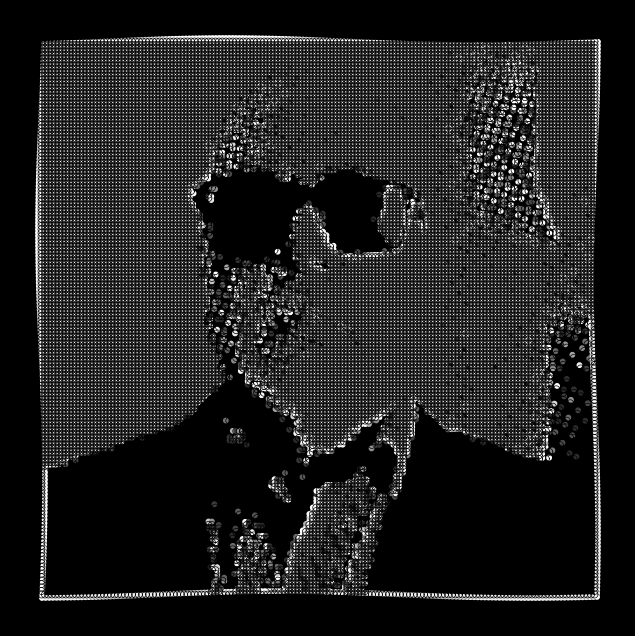

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from scipy.ndimage import zoom
import imageio.v2 as imageio

# --- Parâmetros ---
raio = 0.5              # raio dos círculos
quadros = 60            # número de quadros
fps = 15                # frames por segundo
limiar_preto = 0.05     # ignora pixels muito próximos de preto
zoom_fator = 0.2        # reduz a resolução da imagem
escala = 0.5            # ajuste fino do espaçamento entre pontos
brilho_adicional = 3.0  # aumenta o brilho dos pontos (valores >1 clareiam)

# --- Carrega imagem ---
caminho_imagem = 'imagem.png'  # Substitua pelo caminho da sua imagem
img = imageio.imread(caminho_imagem)

# Converte para escala de cinza
if len(img.shape) == 3:
    img = np.mean(img[..., :3], axis=2)

# Normaliza [0, 1]
img = img / img.max()

# Reduz a resolução da imagem
img_reduzida = zoom(img, zoom_fator)

# Corrige orientação: inverte linhas para evitar rotação -180 ou flip
img_reduzida = img_reduzida[::-1, :]  # inverte verticalmente (flip up-down)

# Encontra coordenadas dos pixels NÃO PRETOS no formato (x, y)
y_coords, x_coords = np.where(img_reduzida > limiar_preto)
coords = np.column_stack((x_coords, y_coords))  # Agora (x, y)

# Centraliza os pontos e aplica escala
xs = coords[:, 0]
ys = coords[:, 1]
centros = [(x - xs.mean(), y - ys.mean()) for x, y in coords]
centros = [(x * escala, y * escala) for x, y in centros]

# Fases baseadas na posição para criar efeito de onda
fases = np.array([(x + y) * 0.5 for x, y in centros])  # fase varia com posição
fases = fases * (2 * np.pi / fases.max())  # normaliza

# --- Configura figura ---
figura, eixos = plt.subplots(figsize=(8, 8))
figura.patch.set_facecolor('black')
eixos.set_facecolor('black')
eixos.set_aspect('equal')
eixos.axis('off')

# Desenha todos os círculos em preto
ang = np.linspace(0, 2 * np.pi, 80)
for cx, cy in centros:
    x_circ = cx + raio * np.cos(ang)
    y_circ = cy + raio * np.sin(ang)
    eixos.plot(x_circ, y_circ, color='black', linewidth=0.5)

# Pontos móveis: cores baseadas no pixel original, com brilho aumentado
# Usamos img_reduzida[y, x] corretamente após o flip
cores_pontos = [
    np.clip(img_reduzida[y, x] * brilho_adicional, 0, 1)
    for x, y in coords
]
cores_rgb = [(c, c, c) for c in cores_pontos]  # tons de cinza mais claros

pontos = eixos.scatter([], [], s=10)

# Função de inicialização
def inicializa():
    pontos.set_offsets(np.empty((0, 2)))
    return (pontos,)

# Função de atualização
def atualiza(indice):
    angulos = indice * (2 * np.pi / quadros) + fases
    xs = [cx + raio * np.cos(a) for (cx, _), a in zip(centros, angulos)]
    ys = [cy + raio * np.sin(a) for (_, cy), a in zip(centros, angulos)]
    pontos.set_offsets(np.c_[xs, ys])
    return (pontos,)

# Atualiza as cores apenas uma vez
pontos.set_color(cores_rgb)

# Cria a animação
animacao = animation.FuncAnimation(
    figura,
    atualiza,
    frames=quadros,
    init_func=inicializa,
    blit=True,
    interval=1000 / fps
)

# Salva em GIF
caminho_gif = 'imagem_em_ondas.gif'
animacao.save(caminho_gif, writer=PillowWriter(fps=fps))

# Para mostrar no Jupyter Notebook
from IPython.display import HTML
HTML(animacao.to_jshtml())

print(f"Animação salva em {caminho_gif}")